In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join
import torch
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm.auto import trange
from contextlib import redirect_stdout

import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom
from utils.pixart_utils import state_dict_convert
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks
from utils.attention_analysis_lib import plot_attention_layer_head_heatmaps, plot_layer_head_score_summary
from utils.attention_analysis_lib import *
from utils.cv2_eval_utils import find_classify_object_masks
from utils.obj_mask_utils import *
from circuit_toolkit.plot_utils import saveallforms

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Pleas

In [ ]:
MAXIMUM = 255
# Create multi-hot masks for each category
def create_multi_hot_token_mask(tokens, target_words, seq_len=None):
    mask = th.zeros(len(tokens) if seq_len is None else seq_len, dtype=th.bool)
    for i, token in enumerate(tokens):
        # Remove the special prefix if present
        clean_token = token.replace('▁', '') if token.startswith('▁') else token
        if clean_token in target_words:
            mask[i] = True
    return mask


def create_object_based_masks(image_list, get_mask_func, map_shape=(8, 8), positive_threshold=180,):
    """
    some mask functions:
    - get_square_pos_others_neg_mask
    - get_triangle_pos_others_neg_mask
    - get_circle_pos_others_neg_mask
    - get_square_pos_others_neg_mask
    - get_triangle_pos_others_neg_mask
    - get_circle_pos_others_neg_mask
    """
    img_msks = []
    for img_idx in range(len(image_list)):
        image = image_list[img_idx]
        df, object_masks = find_classify_object_masks(image)
        obj_masks_resized = [cv2.resize(obj_mask, map_shape, interpolation=cv2.INTER_CUBIC) for obj_mask in object_masks]
        obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
        obj_masks_resized_float = [obj_mask.astype(float) / MAXIMUM for obj_mask in obj_masks_resized]
        img_square_msk, _ = get_mask_func(df, obj_masks_resized_float)
        # img_triangle_msk, _ = get_triangle_pos_others_neg_mask(df, obj_masks_resized_float)
        # img_circle_msk, _ = get_circle_pos_others_neg_mask(df, obj_masks_resized_float)
        img_msks.append(th.from_numpy(img_square_msk).float())
    img_msks = th.stack(img_msks)
    # img_msks.shape # (n_samples, H, W)
    cmb_img_msks = img_msks.repeat(2,1,1)
    cmb_img_msks = cmb_img_msks.unsqueeze(1)
    # cmb_img_msks.shape # (n_samples * 2, 1, H, W)
    cmb_img_msks_vec = cmb_img_msks.flatten(start_dim=-2)
    return cmb_img_msks_vec, img_msks


def print_top_k_scores(scores, k=10, title="Top scores"):
    """
    Print the top k scores and their layer/head indices.
    
    Args:
        scores: tensor of shape (n_layers, n_heads, ...)
        k: number of top scores to print
        title: title for the output
    """
    # Flatten the scores while keeping track of layer and head indices
    scores = th.from_numpy(scores)
    n_layers, n_heads = scores.shape[:2]
    flattened_scores = scores.flatten()
    # Get the top k scores and their indices
    top_k_values, top_k_indices = flattened_scores.topk(k, largest=True)
    print(f"\n{title}:")
    print("-" * 50)
    for i, (value, idx) in enumerate(zip(top_k_values, top_k_indices)):
        # Convert flat index back to layer, head, and remaining dimensions
        remaining_size = scores.numel() // (n_layers * n_heads)
        layer_head_idx = idx // remaining_size
        layer_idx, head_idx = divmod(layer_head_idx.item(), n_heads)
        print(f"Top{i+1}: L{layer_idx}H{head_idx}, Score: {value:.2f}")
        
        
def test_product_prompt_list():
    from itertools import product
    colors = ['red', 'blue']
    target_shapes = ['square', 'triangle', 'circle']
    verticals = ['above', 'below']
    horizontals = ['to the left of', 'to the right of']
    prompts = []
    for c1, c2 in product(colors, colors):
        if c1 == c2:      # skip same‐color pairs
            continue
        for shape1, shape2 in product(target_shapes, target_shapes):
            if shape1 == shape2:
                continue
            for v, h in product(verticals, horizontals):
                prompts.append(f"{c1} {shape1} is {v} and {h} the {c2} {shape2}")
    return prompts

In [6]:
model_run_name = "objrel_singleobj_T5_DiT_B_pilot2" # "objrel_rndembdposemb_DiT_B_pilot" 
# model_run_name = "objrel_T5_DiT_mini_pilot_WDecay" # "objrel_rndembdposemb_DiT_B_pilot" 
ckpt_name = "epoch_4000_step_160000.pth" # "epoch_4000_step_160000.pth" 
text_encoder_type = "T5" 
suffix = ""

### Whole network at bfloat16

In [7]:
text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndemb/caption_feature_wmask'
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
if text_encoder_type == "T5":
    text_encoder = T5EncoderModel.from_pretrained(T5_path, load_in_8bit=False, torch_dtype=torch.bfloat16, )

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
os.makedirs(figdir, exist_ok=True)

config = read_config(join(savedir, 'config.py'))
weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()
num_layers = len(model.blocks)
transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=tokenizer,
    text_encoder=None,
    torch_dtype=weight_dtype,
)
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
# pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
pipeline.tokenizer = tokenizer
pipeline.text_encoder = text_encoder
# pipeline.to(device="cuda", dtype=weight_dtype);
pipeline.to(device="cuda", dtype=torch.bfloat16);
# add attention map store hooks
# pipeline.transformer = replace_attn_processor(pipeline.transformer)
# attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
# attnvis_store.setup_hooks()
# torch.cuda.empty_cache()

2025-07-21 15:59:47,711 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_75706/2804847181.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full 

pipeline.text_encoder.dtype torch.bfloat16
pipeline.transformer.dtype torch.bfloat16
torch.Size([18, 120, 4096])
torch.Size([18, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

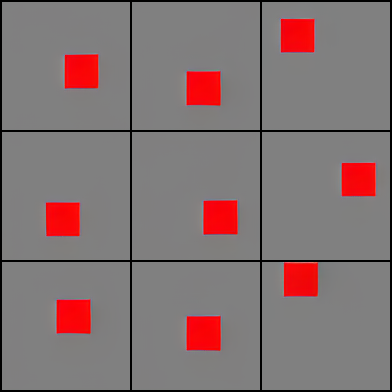

In [13]:
print("pipeline.text_encoder.dtype", pipeline.text_encoder.dtype)
print("pipeline.transformer.dtype", pipeline.transformer.dtype)
out = pipeline("a red square", num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=9, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=None)
pil_images_to_grid(out.images)

pipeline.text_encoder.dtype torch.bfloat16
pipeline.transformer.dtype torch.bfloat16
torch.Size([72, 120, 4096])
torch.Size([72, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

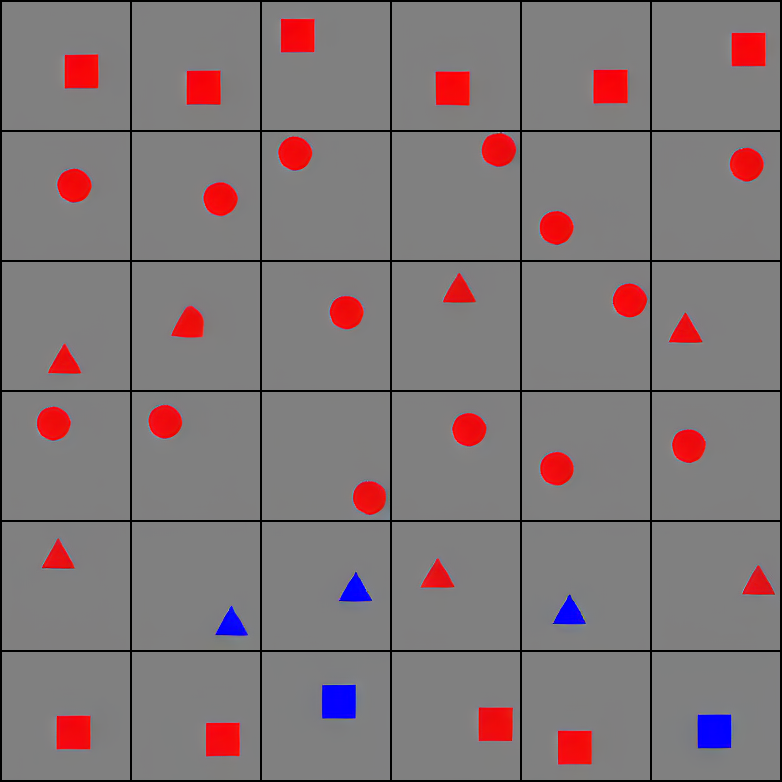

In [ ]:
print("pipeline.text_encoder.dtype", pipeline.text_encoder.dtype)
print("pipeline.transformer.dtype", pipeline.transformer.dtype)
prop = "the"
prompts = [f"{prop} red square", f"{prop} red circle", f"{prop} red triangle",
           f"{prop} blue circle", f"{prop} blue triangle", f"{prop} blue square",
           ]
out = pipeline(prompts, num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=6, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=None)
pil_images_to_grid(out.images)

pipeline.text_encoder.dtype torch.bfloat16
pipeline.transformer.dtype torch.bfloat16
torch.Size([72, 120, 4096])
torch.Size([72, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

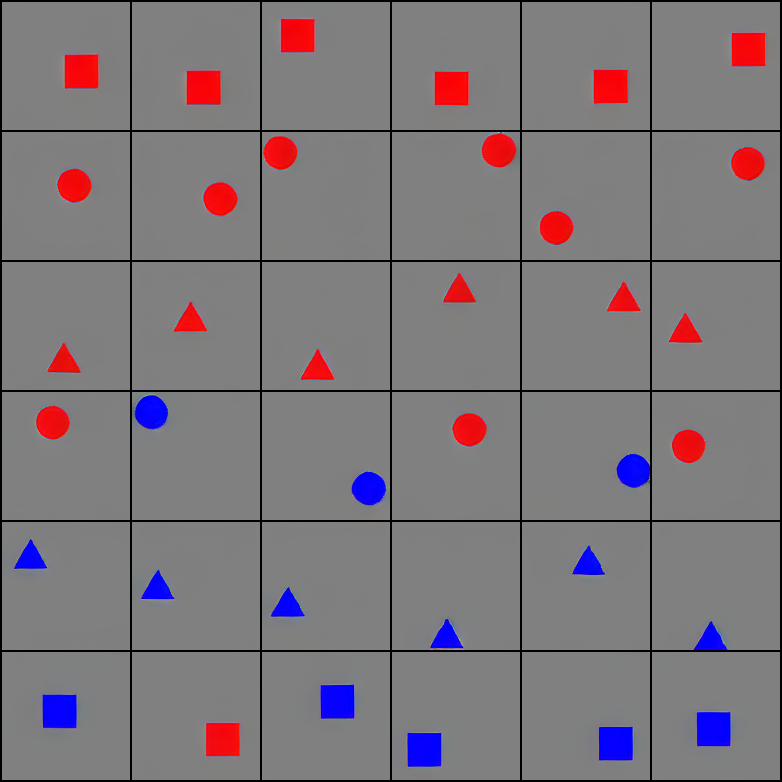

In [20]:
print("pipeline.text_encoder.dtype", pipeline.text_encoder.dtype)
print("pipeline.transformer.dtype", pipeline.transformer.dtype)
prop = "an"
prompts = [f"{prop} red square", f"{prop} red circle", f"{prop} red triangle",
           f"{prop} blue circle", f"{prop} blue triangle", f"{prop} blue square",
           ]
out = pipeline(prompts, num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=6, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=None)
pil_images_to_grid(out.images)

pipeline.text_encoder.dtype torch.bfloat16
pipeline.transformer.dtype torch.bfloat16
torch.Size([72, 120, 4096])
torch.Size([72, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

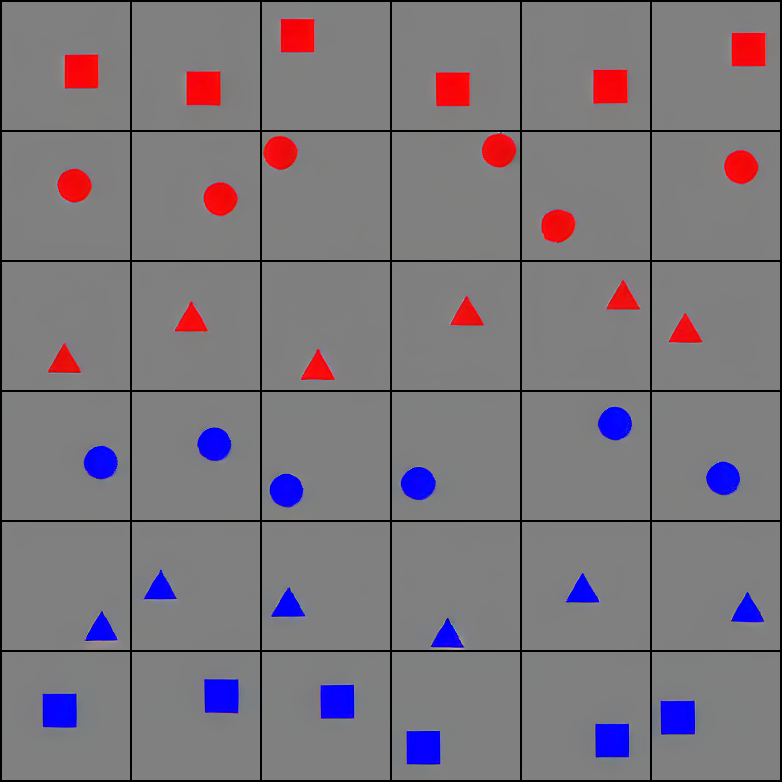

In [21]:
print("pipeline.text_encoder.dtype", pipeline.text_encoder.dtype)
print("pipeline.transformer.dtype", pipeline.transformer.dtype)
prop = "a"
prompts = [f"{prop} red square", f"{prop} red circle", f"{prop} red triangle",
           f"{prop} blue circle", f"{prop} blue triangle", f"{prop} blue square",
           ]
out = pipeline(prompts, num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=6, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=None)
pil_images_to_grid(out.images)

pipeline.text_encoder.dtype torch.bfloat16
pipeline.transformer.dtype torch.bfloat16
torch.Size([24, 120, 4096])
torch.Size([24, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

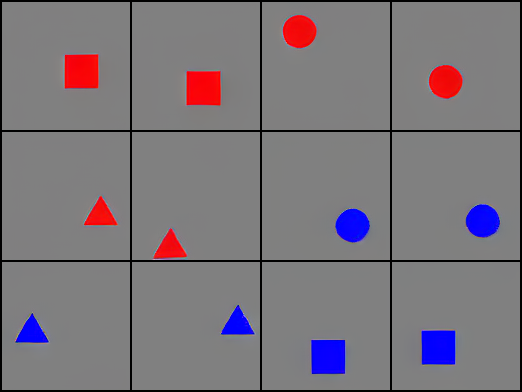

In [14]:
print("pipeline.text_encoder.dtype", pipeline.text_encoder.dtype)
print("pipeline.transformer.dtype", pipeline.transformer.dtype)
prompts = ["a red square", "a red circle", "a red triangle",
           "a blue circle", "a blue triangle", "a blue square",
           ]
out = pipeline(prompts, num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=2, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=None)
pil_images_to_grid(out.images)

pipeline.text_encoder.dtype torch.bfloat16
pipeline.transformer.dtype torch.bfloat16
torch.Size([24, 120, 4096])
torch.Size([24, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

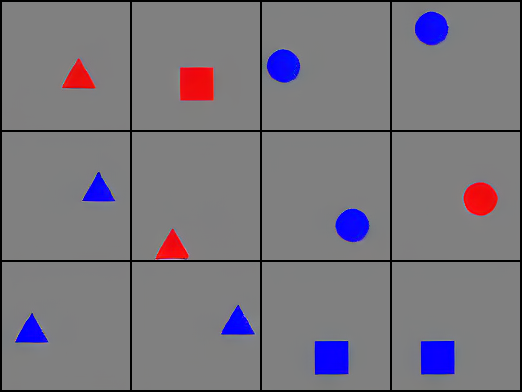

In [15]:
print("pipeline.text_encoder.dtype", pipeline.text_encoder.dtype)
print("pipeline.transformer.dtype", pipeline.transformer.dtype)
prompts = ["red square", "red circle", "red triangle",
           "blue circle", "blue triangle", "blue square",
           ]
out = pipeline(prompts, num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=2, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=None)
pil_images_to_grid(out.images)

pipeline.text_encoder.dtype torch.bfloat16
pipeline.transformer.dtype torch.bfloat16
torch.Size([24, 120, 4096])
torch.Size([24, 120])


  0%|          | 0/14 [00:00<?, ?it/s]

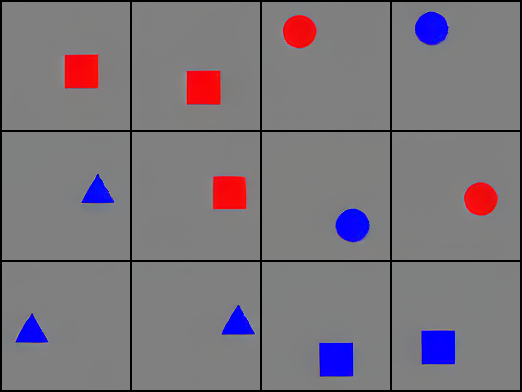

In [16]:
print("pipeline.text_encoder.dtype", pipeline.text_encoder.dtype)
print("pipeline.transformer.dtype", pipeline.transformer.dtype)
prompts = ["a a a red square", "a a a red circle", "a a a red triangle",
           "a a a blue circle", "a a a blue triangle", "a a a blue square",
           ]
out = pipeline(prompts, num_inference_steps=14, guidance_scale=4.5,
         num_images_per_prompt=2, generator=th.Generator(device="cuda").manual_seed(42), prompt_dtype=None)
pil_images_to_grid(out.images)